In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, SimpleRNN, Activation, GRU, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.metrics import Accuracy,FalseNegatives, FalsePositives
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
dataTrain = pd.read_csv(r'C:/Users/I/Desktop/Neural networks/Neural network data/Case3/drugsComTrain_raw.csv')
dataTest = pd.read_csv(r'C:/Users/I/Desktop/Neural networks/Neural network data/Case3/drugsComTest_raw.csv')

In [3]:
#Look at data
dataTrain.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
# Tokenize the text
samples = dataTrain['review']
samplesTest = dataTest['review']

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(samples)
tokenizer.fit_on_texts(samplesTest)
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(samples)
sequencesTest = tokenizer.texts_to_sequences(samplesTest)

word_index = tokenizer.word_index

print('Found %s unique tokens in train data.' % len(word_index))

#pad sequences
Data = pad_sequences(sequences, maxlen=200)
DataTest = pad_sequences(sequencesTest, maxlen=200)

Found 55245 unique tokens in train data.


I though that since before, there was only 3 categories now there would be instead 6: 10 = most positive, 8-9 positive, 6-7 upper moderate, 4-5 lower moderate, 2-3 negative and 1 most negative.<br><br>I thought that splitting good and bad ratings to most positive/negative and positive/negative would be better indicator also I thought that splitting moderate rating to upper/lower moderate rating would be a good idea since now you could see difference in moderate reviews too.

In [5]:
# Create six categories for train and testing 
# label = 5, when rating == 10 most positive
# label = 4, when rating = 8-9 positive
# label = 3, when rating = 6-7 upper moderate
# label = 2, when rating = 4-5 lower moderate
# label = 1, when rating = 2-3 negative
# label = 0, when rating == 1 most negative
Labels = dataTrain['rating'].values
for i in range(len(Labels)):
    x = Labels[i]
    if x == 10:
        Labels[i] = 5
    elif x >= 8:
        Labels[i] = 4
    elif x >= 6:
        Labels[i] = 3
    elif x >= 4:
        Labels[i] = 2
    elif x >= 2:    
        Labels[i] = 1
    else:
        Labels[i] = 0

LabelsTest = dataTest['rating'].values
for i in range(len(LabelsTest)):
    x = LabelsTest[i]
    if x == 10:
        LabelsTest[i] = 5
    elif x >= 8:
        LabelsTest[i] = 4
    elif x >= 6:
        LabelsTest[i] = 3
    elif x >= 4:
        LabelsTest[i] = 2
    elif x >= 2:    
        LabelsTest[i] = 1
    else:
        LabelsTest[i] = 0        

In [6]:
Labels = to_categorical(np.asarray(Labels))
LabelsTest = to_categorical(np.asarray(LabelsTest))
print('Shape of train data tensor:', Data.shape)
print('Shape of train label tensor:', Labels.shape)
print('Shape of test data tensor:', DataTest.shape)
print('Shape of test label tensor:', LabelsTest.shape)

Shape of train data tensor: (161297, 200)
Shape of train label tensor: (161297, 6)
Shape of test data tensor: (53766, 200)
Shape of test label tensor: (53766, 6)


In [7]:
validation_split = 0.3

# split the data into a training set and a validation set
indices = np.arange(Data.shape[0])
np.random.shuffle(indices)
Data = Data[indices]
Labels = Labels[indices]
nb_validation_samples = int(validation_split * Data.shape[0])

x_train = Data[:-nb_validation_samples]
y_train = Labels[:-nb_validation_samples]
x_validation = Data[-nb_validation_samples:]
y_validation = Labels[-nb_validation_samples:]

Since we have 6 classes to classify final layers needs to be 6 instead of 3.

In [8]:
embedding_layer = Embedding(5000,
                            100,
                            input_length=200,
                            trainable=True)

sequence_input = Input(shape=(200,), dtype='int32')

embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)

prediction = Dense(6, activation='softmax')(x)

model = Model(sequence_input, prediction)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          500000    
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 39, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 128)            82048 

In [9]:
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_validation, y_validation))

Train on 112908 samples, validate on 48389 samples
Epoch 1/10
112908/112908 [==============================] - 76s 672us/sample - loss: 1.3546 - acc: 0.4296 - val_loss: 1.2936 - val_acc: 0.4515
Epoch 2/10
112908/112908 [==============================] - 71s 633us/sample - loss: 1.1675 - acc: 0.5141 - val_loss: 1.1544 - val_acc: 0.5227
Epoch 3/10
112908/112908 [==============================] - 73s 647us/sample - loss: 1.0653 - acc: 0.5574 - val_loss: 1.2947 - val_acc: 0.4495
Epoch 4/10
112908/112908 [==============================] - 70s 617us/sample - loss: 0.9551 - acc: 0.6052 - val_loss: 1.2006 - val_acc: 0.5129
Epoch 5/10
112908/112908 [==============================] - 72s 638us/sample - loss: 0.8308 - acc: 0.6624 - val_loss: 1.4782 - val_acc: 0.4760
Epoch 6/10
112908/112908 [==============================] - 69s 613us/sample - loss: 0.7108 - acc: 0.7174 - val_loss: 1.1973 - val_acc: 0.5704
Epoch 7/10
112908/112908 [==============================] - 73s 645us/sample - loss: 0.6082

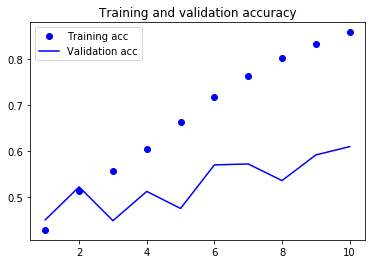

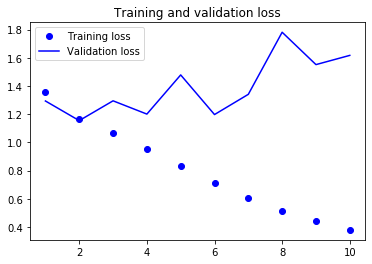

<Figure size 432x288 with 0 Axes>

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.show()

<Figure size 432x288 with 0 Axes>

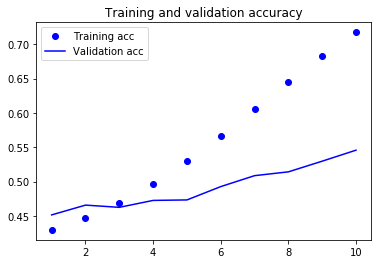

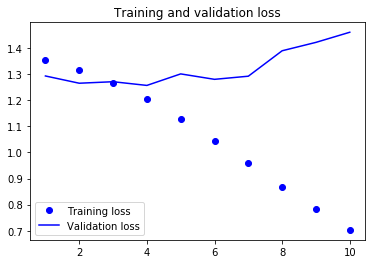

<Figure size 432x288 with 0 Axes>

In [12]:
epochs = range(1, len(acc) + 1)
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

The graphs above show that the model starts overfitting already after 2 epochs. That's fast.

In [13]:
# Find the predicted values for the validation set
y_pred = np.argmax(model.predict(DataTest), axis = 1)
y_true = np.argmax(LabelsTest, axis = 1)

In [14]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred).T
print(cm)
# Calcualte classification report
cr = classification_report(y_true, y_pred)
print(cr)

[[ 4712   678   264   157   216   311]
 [ 1277  2290   557   246   205   151]
 [  512   823  2055   686   426   205]
 [  256   338   845  2513  1448   552]
 [  371   328   545  1355 11083  5655]
 [  171    82   103   253  1955 10142]]
              precision    recall  f1-score   support

           0       0.74      0.65      0.69      7299
           1       0.48      0.50      0.49      4539
           2       0.44      0.47      0.45      4369
           3       0.42      0.48      0.45      5210
           4       0.57      0.72      0.64     15333
           5       0.80      0.60      0.68     17016

    accuracy                           0.61     53766
   macro avg       0.58      0.57      0.57     53766
weighted avg       0.63      0.61      0.61     53766



In [15]:
# Calculate the cohen's kappa, both with linear and quadratic weights
k = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's kappa (linear)    = {k:.3f}")
k2 = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k2:.3f}")

Cohen's kappa (linear)    = 0.501
Cohen's kappa (quadratic) = 0.797


The model overfits as can be seen from the graphs but overall the results aren't that bad since we went from 3 classes to six classes. <br>Cohen's kappa (quadratic) = 0.797 is a good result, Cohen's kappa (linear) = 0.501 not that much. Accuracy in 0.61 isn't that good though.


Okay, lets try what we can achieve with training the model with all the data from Data and Labels for 2 epochs since the graphs result looked to be the best then.

In [16]:
embedding_layer = Embedding(5000,
                            100,
                            input_length=200,
                            trainable=True)

sequence_input = Input(shape=(200,), dtype='int32')

embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)

prediction = Dense(6, activation='softmax')(x)

model = Model(sequence_input, prediction)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [17]:
history = model.fit(Data, Labels,
          batch_size=128,
          epochs=2,
          validation_data=None)

Train on 161297 samples
Epoch 1/2
161297/161297 [==============================] - 105s 649us/sample - loss: 1.3118 - acc: 0.4518
Epoch 2/2
161297/161297 [==============================] - 94s 582us/sample - loss: 1.1300 - acc: 0.5284


In [18]:
# Find the predicted values for the validation set
y_pred = np.argmax(model.predict(DataTest), axis = 1)
y_true = np.argmax(LabelsTest, axis = 1)

In [19]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred).T
print(cm)
# Calcualte classification report
cr = classification_report(y_true, y_pred)
print(cr)

[[ 6063  2468  1209   614   751   821]
 [  533   884   710   358   170    76]
 [  301   719  1366  1307   960   269]
 [    8    59   198   414   390    84]
 [  154   276   666  1974  7373  3474]
 [  240   133   220   543  5689 12292]]
              precision    recall  f1-score   support

           0       0.51      0.83      0.63      7299
           1       0.32      0.19      0.24      4539
           2       0.28      0.31      0.29      4369
           3       0.36      0.08      0.13      5210
           4       0.53      0.48      0.50     15333
           5       0.64      0.72      0.68     17016

    accuracy                           0.53     53766
   macro avg       0.44      0.44      0.41     53766
weighted avg       0.51      0.53      0.50     53766



In [20]:
# Calculate the cohen's kappa, both with linear and quadratic weights
k = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's kappa (linear)    = {k:.3f}")
k2 = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k2:.3f}")

Cohen's kappa (linear)    = 0.387
Cohen's kappa (quadratic) = 0.758


The result isn't good, it seems that having six categories to classify is obviously a lot harder to achieve than with just 3 categories especially with training this few epochs but since the model overfits, there's only regularization that can help with that.<br> Lets's try six classes with glove.6B.100d and glove.6B.200d in Case 3 V2 and V3.